<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/main/Class_06_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 6: Convolutional Neural Networks (CNN) for Computer Vision**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Biology, Health and the Environment](https://sciences.utsa.edu/bhe/), [UTSA](https://www.utsa.edu/)

### Module 3 Material

* Part 6.1: Using Convolutional Neural Networks
* Part 6.2: Using Pre-Trained Neural Networks with Keras
* **Part 6.3: Facial Recognition and Analysis**

### Change your Runtime Now

For this lesson you should pick the A100 GPU hardware accelerator.

## Google CoLab Instructions

You MUST run the following code cell to get credit for this class lesson. By running this code cell, you will map your GDrive to /content/drive and print out your Google GMAIL address. Your Instructor will use your GMAIL address to verify the author of this class lesson.

In [ ]:
# You must run this cell first
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    COLAB = True
    print("Note: Using Google CoLab")
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("**WARNING**: Your GMAIL address was **not** printed in the output below.")
    print("**WARNING**: You will NOT receive credit for this lesson.")
    COLAB = False

Make sure your GMAIL address is included as the last line in the output above.

## Accelerated Run-time Check

You MUST run the following code cell to get credit for this class lesson. The code in this cell checks what hardware acceleration you are using. To run this lesson, you must be running either a Graphics Processing Unit (GPU) or a Tensor Processing Unit (TPU).

In [ ]:
# You must run this cell second

import tensorflow as tf

def check_device():
    # Check for available devices
    devices = tf.config.list_physical_devices()

    # Initialize device flags
    cpu = False
    gpu = False
    tpu = False

    # Check device types
    for device in devices:
        if device.device_type == 'CPU':
            cpu = True
        elif device.device_type == 'GPU':
            gpu = True
        elif device.device_type == 'TPU':
            tpu = True

    # Output device status
    if tpu:
        print("Running on TPU")
    elif gpu:
        print("Running on GPU")
    elif cpu:
        print("Running on CPU")
        print("WARNING: You must run this assigment using either a GPU or a TPU to earn credit")
        print("Change your RUNTIME now!")
    else:
        print("No compatible device found")
        print("WARNING: You must run this assigment using either a GPU or a TPU to earn credit")
        print("Change your RUNTIME now!")

# Call the function
check_device()

Your output should say `Running on GPU` or `Running on TPU`. If, instead, you received a warning, you need to change your Runtime and start over.

# **Facial Recognition and Analysis**


The history of facial recognition using cascaded convolutional networks (CNNs) is quite fascinating and has evolved significantly over the years. Here's a brief overview:

**Early Developments**
* **Viola-Jones Algorithm (2001):** The Viola-Jones algorithm was one of the earliest and most influential methods for real-time face detection. It used Haar-like features and a cascade of classifiers trained with AdaBoost to detect faces quickly and accurately.

**Introduction of CNNs**
* **Convolutional Neural Networks (CNNs):** In the early 2010s, the introduction of CNNs revolutionized facial recognition technology. CNNs could learn complex features directly from data, making them more robust to variations in pose, expression, and lighting.

**Cascaded CNNs**
* **Cascade Architecture:** To improve performance and efficiency, researchers developed cascaded CNN architectures. These architectures use multiple stages of CNNs, where each stage refines the results of the previous one. This approach helps in quickly rejecting non-face regions and focusing on challenging candidates.

**MTCNN (2016)**
* **Multitask Cascaded Convolutional Networks (MTCNN):** MTCNN is a notable example of a cascaded CNN architecture designed for face detection and alignment. It consists of three stages: PNet (Proposal Network), RNet (Refine Network), and ONet (Output Network)4. MTCNN can detect faces and facial landmarks with high accuracy and efficiency.

## Download Images for Class_03_3

The code in the cell below creates a custom function for this lesson called `store_image()` that uses `urllib.request()`.

`urllib.request()` is a module in Python's standard library used for opening and reading URLs. It's part of the larger urllib package, which handles URL operations like fetching data across the web.

The cell then reads several image files from the course file server that we will use in this lesson.

In [ ]:
# Download images

import urllib.request

# Function to download and store images
def store_image(url, local_file_name):
  with urllib.request.urlopen(url) as resource:
    with open(local_file_name, 'wb') as f:
      f.write(resource.read())

# Images used in this lesson
store_image('https://biologicslab.co/BIO1173/images/class_06/ChineseAngry.jpg','ChineseAngry.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TaylorSwift1.jpg','Taylor1.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TaylorSwift2.jpg','Taylor2.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TaylorSwift3.jpg','Taylor3.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TaylorDisgust.jpg','TaylorDisgust.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TaylorDisgust2.jpg','TaylorDisgust2.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TravisKelce1.jpg','Travis1.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TravisKelce2.jpg','Travis2.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TravisKelce3.jpg','Travis3.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TaylorTravis.jpg','TaylorTravis.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TaylorGroup.jpg','TaylorGroup.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/TaylorEighmy.jpg','TaylorEighmy.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/WomanGorilla.jpg','WomanGorilla.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/ET.jpg','ET.jpg')
store_image('https://biologicslab.co/BIO1173/images/class_06/SheldonSmile.jpg','SheldonSmile.jpg')

# **The `face_recognition` package**

The **face_recognition** package is a simple and easy-to-use facial recognition library for Python. It is built on top of **`dlib`** and **`OpenCV`**, leveraging `dlib's` state-of-the-art face recognition capabilities. Here are some key features and uses of the face_recognition package:

#### **Key Features:**
* **Face Detection:** It can detect faces in images and videos.
* **Face Landmarks:** It can find and manipulate facial features such as eyes, nose, mouth, and chin.
* **Face Encoding:** It can generate face encodings, which are numerical representations of faces that can be used for recognition.
* **Face Recognition:** It can recognize and compare faces in images.
* **Command-Line Tool:** It includes a simple command-line tool for performing face recognition on folders of images.

#### **Typical Uses:**
* **Photo Organization:** Automatically organizing photos by recognizing and grouping images of the same person.
* **Security Systems:** Implementing access control systems that use facial recognition to grant or deny access.
* **Social Media:** Identifying and tagging friends in photos.
* **Real-Time Applications:** Building real-time face recognition systems for various applications.

In [ ]:
# Install face_recognition package

!pip install face_recognition

If the code is correct, you should see something similar to the following output:

~~~text
Requirement already satisfied: face_recognition in /usr/local/lib/python3.11/dist-packages (1.3.0)
Requirement already satisfied: face-recognition-models>=0.3.0 in /usr/local/lib/python3.11/dist-packages (from face_recognition) (0.3.0)
Requirement already satisfied: Click>=6.0 in /usr/local/lib/python3.11/dist-packages (from face_recognition) (8.1.8)
Requirement already satisfied: dlib>=19.7 in /usr/local/lib/python3.11/dist-packages (from face_recognition) (19.24.2)
Requirement already satisfied: numpy in /usr/local/lib/python3.11/dist-packages (from face_recognition) (1.26.4)
Requirement already satisfied: Pillow in /usr/local/lib/python3.11/dist-packages (from face_recognition) (11.1.0)
~~~

## **Create Custom Function `face_detector()`**

Now that we have installed the `face_recognition()` package, we can use it to create a custom `face_detector()` function.

#### **Summary of the Custom Face Detector Code**

This program is a custom face detection tool that identifies faces in an input image, draws bounding boxes around them, optionally saves the output image with the boxes, and returns the face bounding box coordinates.

#### Key Steps:
1. **Load the Image:**
   - The image is loaded from the specified file path (`image_path`) using OpenCV and converted to RGB format.

2. **Resize the Image:**
   - The image is resized to specified dimensions (`resize_dim`, default is 640x480 pixels) for processing.

3. **Detect Faces:**
   - The `face_recognition.face_locations` method is used to detect faces in the image, returning bounding box coordinates for each face in the format `(top, right, bottom, left)`.

4. **Draw Bounding Boxes:**
   - Detected faces are outlined with red bounding boxes drawn using OpenCV's `cv2.rectangle`.

5. **Display the Image:**
   - The processed image, with bounding boxes, is displayed using Matplotlib.

6. **Optional Save:**
   - If `save_output=True`, the image with bounding boxes is saved to a specified file path (`output_path`) or a default file named "output_image.jpg".

7. **Output Face Details:**
   - The program prints the number of faces detected and the coordinates of each face.
   - It returns a list of bounding boxes for all detected faces.

#### Example Function Call:
```python
face_locations = face_detector(
    image_path="path/to/image.jpg",
    resize_dim=(800, 600),  # Optional resizing dimensions
    save_output=True,
    output_path="detected_faces.jpg"
)


In [ ]:
# Create custom face detector

import face_recognition
import cv2
import matplotlib.pyplot as plt
import os

def face_detector(image_path, resize_dim=(640, 480), save_output=False, output_path=None):
    """
    Detect faces in an image and display or optionally save the result.

    Args:
    - image_path (str): Path to the input image.
    - resize_dim (tuple): Dimensions to resize the image (width, height). Default is (640, 480).
    - save_output (bool): Whether to save the output image with bounding boxes. Default is False.
    - output_path (str): Path to save the output image. Ignored if save_output is False.

    Returns:
    - face_locations (list): List of face bounding boxes in the format (top, right, bottom, left).
    """
    # Load the image
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to the specified dimensions
    resized_image = cv2.resize(rgb_image, resize_dim)

    # Detect face locations in the resized image
    face_locations = face_recognition.face_locations(resized_image)

    # Draw bounding boxes on the image
    for (top, right, bottom, left) in face_locations:
        cv2.rectangle(resized_image, (left, top), (right, bottom), (255, 0, 0), 2)  # Red bounding box

    # Display the image
    plt.imshow(resized_image)
    plt.axis('off')
    plt.show()

    # Save the output image if requested
    if save_output:
        if output_path is None:
            output_path = os.path.join(os.getcwd(), "output_image.jpg")  # Default output path
        output_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, output_image)
        print(f"Output image saved to {output_path}")

    # Print and return face locations
    print(f"Detected {len(face_locations)} face(s).")
    for i, (top, right, bottom, left) in enumerate(face_locations):
        print(f"Face {i + 1}: Top: {top}, Right: {right}, Bottom: {bottom}, Left: {left}")

    return face_locations


### Example 1A: Detect Face

Let's start by giving our `face_detector()` an easy image to analyse--a close-up portrait of Taylor Swift.

In [ ]:
# Example 1: Detect and Display Image

# Define image path
IMAGE_PATH = 'Taylor1.jpg'

face_detector(IMAGE_PATH)

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_03/class_03_3_image01F.png)

Our `face_detector()` function had no trouble seeing Taylor Swift's face and putting a red "bounding box" around it. Here are the coordinates for the "box":

~~~text
Face 1: Top:99m Right: 419, Bottom: 420, Left: 98
~~~

We can now classify any facial image -- just specify the URL of any image you wish to classify.

### Example 1B: Detect Face

Does our `face_detector()` function work as well with a male face? Let's see how our function works with another person with the same first name `Taylor`, Taylor Eighmy -- The President of The University of Texas at San Antonio?

The code in the cell below uses the function `face_detector()` to analyze an image of Taylor Eighmy (`TaylorEighmy.jpg`).

In [ ]:
# Example 1B: Detect Face

# Define image path
IMAGE_PATH = 'TaylorEighmy.jpg'

face_detector(IMAGE_PATH)

If the code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_03/class_03_3_image02F.png)

Our `face_detector()` again has no trouble "seeing"  a face in the image.

Here are the coordinates for the "box" the function placed around President Eighmy's face:

~~~text
[98, 366, 284, 180]
~~~



### **Exercise 1A: Detect Face**

So far, we have only used images that contained a portrait of a person. Can our face detector find the face in an image of the whole person?

In the cell below, use the function `face_detect()` to analyze an image of Taylor Swift where she is standing outside (`Taylor2.jpg`).

In [ ]:
# Insert your code for Exercise 1A here

# Define image path
IMAGE_PATH = 'Taylor2.jpg'

face_detector(IMAGE_PATH)

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_03/class_03_3_image03F.png)

This time our `face_detector()` couldn't pick out Taylor's face from the background clutter.


### **Exercise 1B: Detect Face**

An interesting question is "How specific is our `face_detector()` function?" For example, can it tell the difference between a human face and the face of a non-human primate like a baby gorilla?

In the cell below, use the function `face_detector()` to analyze an image of a Woman holding a baby gorilla (`WomanGorilla.jpg`).

In [ ]:
# Insert your code for Exercise 1B here

# Define image path
IMAGE_PATH = 'WomanGorilla.jpg'

face_detector(IMAGE_PATH)

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_03/class_03_3_image04F.png)

This time our `face_detector()` picked-up the woman's face, but not the face of the baby gorilla.

### **Exercise 1C: Detect Face**

What about a face that is clearly not human, but has some human-like features?

In the cell below, use the function `face_detector()` to analyze an image of .**ET**, the Extra-Terrestrial, from the 1982 science fiction film directed by Steven Spielberg (`ET.jpg`).

In [ ]:
# Insert your code for Exercise 1C here

# Define image path
IMAGE_PATH = 'ET.jpg'

face_detector(IMAGE_PATH)

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image03.png)

Since there is no bounding box, and no printout, our `face_detector()` function didn't find any face when "looking" at ET's picture. So clearly there are limits to what is detected as a human face.

### **Exercise 1D: Detect Faces**

One final question we might want to ask is how good is our `face_detector()` function at identifying multiple faces of a group of people in a "normal" picture--a picture that you might take will your cell phone?

In the cell below, use `face_detector()` to analyze an image of Taylor Swift, Travis Kelse and a third person in the image `TaylorTravis.jpg`).

In [ ]:
# Insert your code for Exercise 1D here
# Define image path
IMAGE_PATH = 'TaylorTravis.jpg'

face_detector(IMAGE_PATH)

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_03/class_03_3_image05F.png)

Even though Taylor Swift isn't looking straight into the camera, our `face_detector()` function had no problem "seeing" her face along with the faces of the other two men in the picture.

# **VGG16 Model**

The **VGG16 model** is a convolutional neural network (CNN) architecture developed by the Visual Geometry Group (VGG) at the University of Oxford. It's widely used for image classification tasks. Here are some key points about VGG16:

**Architecture**
* **16 Layers:** The model has 16 layers with weights, including 13 convolutional layers and 3 fully connected layers.
* **3x3 Filters:** It uses small 3x3 convolution filters throughout the network.
* **Max Pooling:** It includes max pooling layers to reduce the spatial dimensions of the feature maps.
* **Fully Connected Layers:** The final layers are fully connected, followed by a softmax activation function for classification.

**Pre-trained Weights**
* **ImageNet Pre-training:** The VGG16 model is often pre-trained on the ImageNet dataset, which contains over a million images across 1,000 categories.
* **Transfer Learning:** This pre-trained model can be fine-tuned for specific tasks, making it a popular choice for transfer learning.

**Applications***
* **Image Classification:** VGG16 is used for classifying images into different categories, such as identifying objects, animals, or plants in images.
* **Feature Extraction:** It can be used to extract features from images, which can then be used for other machine learning tasks1.


In order to use the VGG16 model, we need to create the 2 following functions.

### **Create Function `load_image()`**

The `load_image()` function is designed to load an image from a file, preprocess it, and prepare it for input into a neural network model.

#### **Explanation of load_image Function:**
1. **Load the Image:** The function uses the PIL library to open the image file specified by the filename and ensures that the image is in RGB format, which is essential for consistent processing.
2. **Resize the Image:** It resizes the image to 224x224 pixels, which is the input size expected by many neural network models, like VGG16.
3. **Convert Image to Numpy Array:** The function converts the image into a NumPy array, a common format used for numerical computations in machine learning.
4. **Expand Dimensions:** It adds an extra dimension to the image array to match the expected input shape for the neural network. This extra dimension represents the batch size.
5. **Preprocess the Image:** The function applies model-specific preprocessing to the image array. This step might normalize the pixel values to a range suitable for the neural network model.
6. **Return the Preprocessed Image:** Finally, the function returns the preprocessed image array, ready to be used as input for the neural network model.

In [ ]:
# Create function load_image()

from PIL import Image
import numpy as np

# Load and preprocess the image
def load_image(filename):
    img = Image.open(filename).convert('RGB')  # Ensure image is in RGB format
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

### **Create Function `predict_image()`**

The code in the cell below creates a function called `predict_image()`. Here is a step-by-step explanation of this function:

1. **Input Parameter:**
* **img_array:** This is the input image array that you want to classify. It should be preprocessed and in the format expected by the VGG16 model.

2. **Model Prediction:**
* **preds = model_VGG16.predict(img_array):** This line uses the predict method of the model_VGG16 (a pre-trained VGG16 model) to make predictions on the input image array. The predict method returns a list of probabilities for each of the classes in the dataset.

3, **Decode Predictions:**

* **return decode_predictions(preds, top=5)[0]:** This line decodes the predicted probabilities into human-readable class names and probabilities. The decode_predictions function takes the following parameters:
  - **preds:** The list of predicted probabilities returned by the model.
  - **top=5:** This parameter specifies that we want the top 5 predictions.

* The [0] at the end selects the top 5 predictions for the first image in the input array (assuming img_array could contain multiple images).

In [ ]:
# Create function predict_image()

from PIL import Image
import numpy as np

# Predict the image
def predict_image(img_array):
    preds = model_VGG16.predict(img_array)
    return decode_predictions(preds, top=5)[0]

### Example 2: Analyze Non-Facial Content

The code in the cell below uses our 2 new functions `load_image()` and `predict_image()` to analyze the same picture of Taylor Swift that you used above in **Exercise 1A**. The VGG16 model is _not_ trained to find faces, but to analyze everything else it "sees" in the image.

In [ ]:
# Example 2: Analyze Non-Facial Content

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Define Image path
IMAGE_PATH = "Taylor2.jpg"

# Load the VGG16 model
model_VGG16 = VGG16(weights='imagenet', include_top=True)

# Load image
img_path = IMAGE_PATH
img_array = load_image(img_path)

# Make predictions
predictions = predict_image(img_array)

# Display the image and predictions
plt.imshow(Image.open(img_path))
plt.axis('off')
plt.show()

for pred in predictions:
    print(f"{pred[1]}: {pred[2]*100:.2f}%")

If the code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_03/class_03_3_image06F.png)

### **Analysis of the output**

Let's take a closer look at the output since it gives us some insight into how the **VGG16** neural network extracts features and classifies them.

#### **Downloaded Files**

First, at the top of the output, you can see that the code downloaded two files from the Internet, (1) `vgg16_weights_tf_dim_ordering_tf_kernels.h5` and (2) `imagenet_class_index.json`.  

1. The file `vgg16_weights_tf_dim_ordering_tf_kernels.h5` is a pre-trained weight file for the VGG16 model. Here's a breakdown of what the file name means:
  - **vgg16_weights:** Indicates that it contains the weights for the VGG16 model.
  - **tf_dim_ordering_tf_kernels:** Specifies that the weights are ordered for TensorFlow (tf) and use TensorFlow kernels.
  - **h5:** The file format, which is HDF5, a data model, library, and file format for storing large and complex data.

>This file can be used to load the pre-trained VGG16 model in TensorFlow or Keras, allowing you to leverage the model's learned features for your own image classification tasks without having to train it from scratch.

2. The `imagenet_class_index.json` file is a **JSON file** that contains a mapping of ImageNet class indices to human-readable class names. ImageNet is a large visual database designed for use in visual object recognition research, and it contains millions of images categorized into thousands of different classes.

#### **Image Analysis**

By "looking" at the image of Taylor Swift, the **VGG16 model** correctly identifies that image contained a pair of jeans (jean: 70.75%), but since the image did not include a full view of her legs, the model thought there was a 7% chance that it "saw" a miniskirt (miniskirt: 6.84%).

The model was unsure if it "saw" Taylor wearing a `cardigan` sweater or a sweatshirt. The VGG16 model didn't get either item exactly right, but Taylor wasn't really wearing her sweater in a typical manner either.

Finally, Taylor Swift's heavy eye make-up made it appear to the model, that there was a small chance of a pair of sunglasses (sunglasses: 1.82%).

### **Exercise 2: Analyze Non-Facial Content**

In the cell below, use the VGG16 model to make predictions about the contents of an image of Kelse Travis in a football uniform (`Travis2.jpg`).

In [ ]:
# Insert your code for Exercise 2 here

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Define Image path
IMAGE_PATH = "Travis2.jpg"

# Load the VGG16 model
model_VGG16 = VGG16(weights='imagenet', include_top=True)

# Load image
img_path = IMAGE_PATH
img_array = load_image(img_path)

# Make predictions
predictions = predict_image(img_array)

# Display the image and predictions
plt.imshow(Image.open(img_path))
plt.axis('off')
plt.show()

for pred in predictions:
    print(f"{pred[1]}: {pred[2]*100:.2f}%")

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image09.png)

Again the output is interesting. The VGG16 model correctly identifies that image contained a football helmet (`football_helmet: 57.98%`) even though only a small part (the face mask) is actually visible in the image. Somewhat bizarrely, the model thought it "saw" Kelse wearing a "basketball uniform" (basketball: 29.98%).

## **Face Extraction from Image**

**Face extraction** in Convolutional Neural Networks (CNNs) refers to the process of detecting and isolating faces from an image before feeding them into a CNN for further processing, such as recognition or classification. This step is crucial because it ensures that the CNN focuses only on the relevant part of the image (the face) and ignores the background or other irrelevant detail.

### **Create Function `extract_face_from_image()`**

The code in the cell below, creates a function called `extract_face_from_image()`. The function uses the MTCNN neural network to extract facial image(s) from a larger image and then returns the extracted face as an image to the program that called the function.

In [ ]:
# Create extract face function

from numpy import asarray
from PIL import Image
import face_recognition
import matplotlib.pyplot as plt

def extract_face_from_image(image_path, required_size=(224, 224)):
    """
    Detect faces in an image and extract them as resized arrays.

    Args:
    - image_path (str): Path to the input image.
    - required_size (tuple): Desired dimensions for the output face images (width, height).

    Returns:
    - face_images (list): List of face arrays, resized to the required size.
    """
    # Load the image
    image = plt.imread(image_path)

    # Detect face locations
    face_locations = face_recognition.face_locations(image)

    # List to store extracted face arrays
    face_images = []

    # Loop through detected faces
    for face in face_locations:
        # Extract the bounding box for the face
        top, right, bottom, left = face

        # Extract the face using the bounding box
        face_boundary = image[top:bottom, left:right]

        # Resize the face to the required dimensions
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = asarray(face_image)

        # Append the resized face array to the list
        face_images.append(face_array)

    return face_images


### Example 3: Extract Face from Image

The code in the cell below, uses our function `extract_face_from_image()` to extract Taylor Swift's face from the image of her used above in Example 2.

![__](https://biologicslab.co/BIO1173/images/class_06/TaylorSwift2.jpg)

In [ ]:
# Example 3: Extract face

# Define Image path
IMAGE_PATH = "Taylor2.jpg"

extracted_face = extract_face_from_image(IMAGE_PATH)

# Display the first face from the extracted faces
plt.imshow(extracted_face[0])
plt.show()

If the code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image11.png)

Our `extract_face_from_image()` function had no trouble with this image.

### **Exercise 3: Extract Face from Image**

In the cell below, use our custom function `extract_face_from_image()` to extract Kelse Travis' face from the image of him standing in his football uniform (`Travis2.jpg`) that was used above in **Exercise 2**.

![__](https://biologicslab.co/BIO1173/images/class_06/TravisKelce2.jpg)

In [ ]:
# Insert your code for Exercise 3 here

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image12.png)

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image12.png)

## **CNNs to Automatically Blur Faces in Images**

Automatically **blurring faces** in images is important for several reasons, especially when it comes to privacy, security, and ethical considerations:

#### **Privacy Protection**
* **Personal Privacy:** Blurring faces helps protect individuals' privacy by making them less recognizable in images. This is crucial in situations where individuals have not given their consent to be photographed or identified.
* **Data Privacy Regulations:** Regulations like the General Data Protection Regulation (GDPR) in the EU emphasize the importance of protecting personal data. Automatically blurring faces ensures compliance with these regulations.

#### **Security Concerns**
* **Anonymity:** In sensitive contexts, such as protests or political gatherings, blurring faces can protect individuals from potential repercussions or surveillance.
* **Witness Protection:** In law enforcement and legal contexts, blurring faces of witnesses and victims can protect their identities and ensure their safety.

#### **Ethical Considerations**
* **Consent:** It is ethically responsible to blur faces when sharing images of people who haven't explicitly consented to be photographed or identified. This is especially important in public places or when dealing with vulnerable populations, such as children.
* **Minimizing Harm:** By blurring faces, content creators and organizations can minimize the potential harm that could come from individuals being identified without their permission.

#### **Public Sharing and Media**
* **Social Media:** Automatically blurring faces is particularly important for images shared on social media, where privacy settings might not be strict, and images can spread quickly.
* **News and Journalism:** In journalism, blurring faces can protect the identities of individuals in sensitive or dangerous situations while still conveying important information.

#### **Example Use Cases**
* **CCTV Footage:** Automatically blurring faces in CCTV footage can help maintain the privacy of individuals who are not involved in any incidents being monitored.
* **Photo Albums:** Photo-sharing platforms can use face blurring to respect the privacy of people in group photos before these images are made public.

Now that correct packages have been loaded, we can create our image generators.


### Example 4: Blur Faces in an Image

Let's see what we can do with the `face_recognition` package. One practical function is to automatically find faces in an image and blur it.

The code in the cell below uses the same image you used in **Exercise 1D** above.

![__](https://biologicslab.co/BIO1173/images/class_06/TaylorTravis.jpg)


In [ ]:
# Example 4: Blur Faces

import face_recognition
import cv2
from google.colab.patches import cv2_imshow

# Path to group image
GROUP_PHOTO = "TaylorTravis.jpg"

# Load the image
image = face_recognition.load_image_file(GROUP_PHOTO)

# Find all face locations
face_locations = face_recognition.face_locations(image)

# Blur faces
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
for (top, right, bottom, left) in face_locations:
    face = image[top:bottom, left:right]
    blurred_face = cv2.GaussianBlur(face, (99, 99), 30)
    image[top:bottom, left:right] = blurred_face

# Display the image with blurred faces
cv2_imshow(image)



If the code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image15.png)

The code worked as expected.

### **Exercise 4: Blur Faces**

In the cell below, finds faces and blur them in a group image called `TaylorGroup.jpg`.


![__](https://biologicslab.co/BIO1173/images/class_06/TaylorGroup.jpg)




In [ ]:
# Insert your code for Exercise 4 here


If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image16.png)

## **Facial Analysis**

Besides finding and blurring faces, the `facial_recognition` package can also be used to find facial features by identifying and returning the locations of facial landmarks such as eyes, nose, mouth, and chin.

In order to utilize this capability, we need to create a new function called `analyze_facial_attribute()` in the cell below.

### **Create Function `analyze_facial_attributes()`**

#### Explanation of the `analyze_facial_attributes` function:

1. **Load the Image**: The function uses the `face_recognition` library to load an image from the specified file path.
2. **Find Face Locations**: It detects all face locations in the image and stores the coordinates of these faces.
3. **Find Facial Features**: The function identifies various facial features (landmarks) like eyes, nose, and mouth for each detected face.
4. **Display the Image**: It uses the `PIL` library to open and display the image with `matplotlib`, turning off axis labels for a cleaner view.
5. **Plot Facial Features**: For each set of facial features, it plots the points using `matplotlib`, connecting the landmarks with lines to visualize the features.
6. **Show Image with Landmarks**: The function displays the image with the overlaid facial landmarks.
7. **Return Results**: Finally, it returns the face locations and facial landmarks.

In [ ]:
# Create function analyze_facial_attributes()

import face_recognition
import matplotlib.pyplot as plt
from PIL import Image

def analyze_facial_attributes(image_path):
    # Load the image
    image = face_recognition.load_image_file(image_path)

    # Find all face locations in the image
    face_locations = face_recognition.face_locations(image)

    # Find all facial features in the image
    face_landmarks_list = face_recognition.face_landmarks(image)

    # Display the image with face landmarks
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')

    for face_landmarks in face_landmarks_list:
        for feature, points in face_landmarks.items():
            points = [tuple(point) for point in points]
            x, y = zip(*points)
            plt.plot(x, y, marker='o')

    plt.show()

    return face_locations, face_landmarks_list

### Example 5: Analyze Facial Attributes

The code in the cell below uses our function `analyze_facial_attributes()` to identify and analyze the facial features in an image of Taylor Swift (`Taylor1.jpg`).


![___](https://biologicslab.co/BIO1173/images/class_06/TaylorSwift1.jpg)

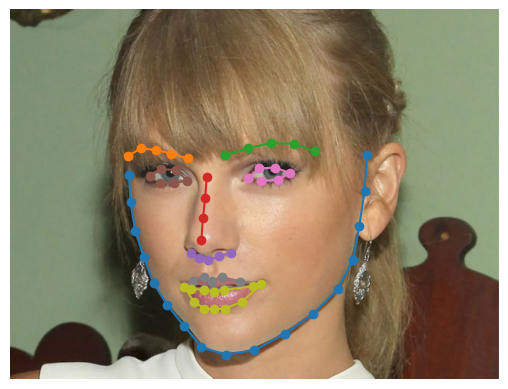

In [ ]:
# Example 5: Analyze Facial Attributes


# Define Image path
image_path = 'Taylor1.jpg'

# Analyze facial attributes
face_locations, face_landmarks_list = analyze_facial_attributes(image_path)

If the code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image13.png)

Each colored line resprents a different facial feature (attribute) extacted from the image.


### **Exercise 5: Analyze Facial Attributes**

In the cell below, use `analyze_facial_attributes()` to analyze the facial features in an image of Travis Kelse (`Travis3.jpg`).


![___](https://biologicslab.co/BIO1173/images/class_06/TravisKelce3.jpg)

In [ ]:
# Insert your code for Exercise 5 here

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image17.png)

## **Facial Recognition using `DeepFace`**

**DeepFace** is a **deep learning facial recognition system** developed by a research group at [Facebook](https://en.wikipedia.org/wiki/Facebook). It was designed to identify human faces in digital images with high accuracy.

Here are some key points about `DeepFace`:

* **Architecture:** DeepFace uses a nine-layer neural network with over 120 million connection weights. This complex architecture allows it to achieve impressive accuracy in facial recognition tasks.

* **Training Data:** The system was trained on four million images uploaded by Facebook users. This extensive dataset helped the model learn a wide variety of facial features and variations.

* **Accuracy:** DeepFace has an accuracy of 97.35% on the Labeled Faces in the Wild (LFW) dataset, which is comparable to human performance. This means it can sometimes outperform humans in recognizing faces.

* **Applications:** Initially, DeepFace was used to alert Facebook users when their face appeared in any photo posted on the platform. Users could then choose to remove their face from the photo if they wished.

DeepFace represents a significant advancement in facial recognition technology and has influenced many subsequent developments in the field.

## **Install `deepface`**

Run the next cell to install DeepFace into your current Colab environment.

The command `!pip install -U deepface` is used to install or upgrade the DeepFace library in a Python environment.

Here’s a breakdown of what the command does:

* **!pip:** The exclamation mark (!) indicates that this command should be executed in a Jupyter notebook or similar environment where the ! symbol is used to run shell commands.

* **install:** This tells pip (the Python package installer) to install a package.

* **-U:** This flag stands for "upgrade" and tells pip to upgrade the package to the latest version if it's already installed.

* **deepface:** This specifies the name of the package to be installed or upgraded, which in this case is DeepFace.

So, running this command will either install the DeepFace library if it’s not already present in your environment or upgrade it to the latest version if it is already installed. To prevent extra output being printed to your notebook, the `pip` install command if followed by `> /dev/null`.

In [ ]:
!pip install -U deepface > /dev/null

If the code is correct, you shouldn't see any output.

--------------------------------------------------------


## **A Short History of Emotion Detection**

The history of emotion detection using Convolutional Neural Networks (CNNs) reflects the broader advancements in both technology and our understanding of human emotions. Here's an overview:

#### Early Days of Emotion Recognition
- **19th Century**: The formal study of emotions can be traced back to Charles Darwin, who suggested that emotional expressions have evolved and serve social functions. Although his work did not benefit from modern technology, it laid the groundwork for understanding how behaviors related to emotions could be studied scientifically.
- **1970s**: Researchers began to employ more systematic methods to study emotional expressions. The emergence of facial coding systems, such as Paul Ekman's Facial Action Coding System (FACS), transformed emotion recognition research. FACS categorized facial movements and expressions, allowing researchers to conduct more precise analysis based on visible emotional cues.

#### Rise of Machine Learning and AI
- **Late 20th Century**: The turning point for emotion recognition technologies came with the advent of machine learning (ML) and artificial intelligence (AI). By the early 2000s, the availability of more extensive datasets and more powerful computing resources allowed researchers to explore various algorithms for facial recognition and emotion detection.
- **Early 2000s**: Researchers began to use machine learning techniques to automate emotion recognition. These early attempts relied on basic computer vision techniques but struggled to accurately interpret the nuances of human expressions.

#### Advancements in Deep Learning
- **2010s**: The introduction of deep learning and CNNs revolutionized emotion detection. CNNs, with their ability to learn hierarchical representations of data, proved to be highly effective in recognizing and classifying emotions from facial expressions.
- **Recent Developments**: Modern CNNs have achieved impressive accuracy in emotion recognition tasks. Researchers have also explored the intrinsic ability of CNNs to represent the affective significance of visual input, suggesting that emotional perception might be an intrinsic property of the visual cortex.

#### Current Trends and Applications
- **Applications**: Emotion detection by CNNs is now used in various applications, including social media, customer service, healthcare, and security systems.
- **Ethical Considerations**: As emotion detection technologies become more widespread, ethical considerations regarding privacy, consent, and the potential misuse of these technologies have come to the forefront.

The history of emotion detection by CNNs showcases the rapid evolution of technology and its impact on our ability to understand and interact with human emotions. It's an exciting field that continues to grow and develop, offering new possibilities for enhancing human-computer interaction.

-------------------------------------------


## **Detect Emotion with `DeepFace`**

The `DeepFace` system can analyze facial attributes to predict the age, gender, emotion, and race/ethnicity of the person in the image.

In the cell below, we create a function called `detect_emotion()` that uses the DeepFace system.

### **Create function `detect_emotion()`**

The code in the cell below creates a custom function called `detect_emotion()`. This code defines a function detect_emotion that takes an image file path as an input, analyzes the image for emotions using DeepFace, and then displays the detected emotions along with the image. Here's a breakdown of what the code does:

* **Function Definition:** The function detect_emotion is defined with the parameter image_path, which represents the file path of the image to be analyzed.
* **Analyze the Image**: The DeepFace library's analyze function is used to analyze the image for emotions. It takes the image path and a list of actions (in this case, ['emotion']) to perform the emotion analysis. The result is stored in the variable result.
* **Print Detected Emotion:** The dominant emotion detected in the image is printed using print(f"Detected emotion: {result[0]['dominant_emotion']}"). It also prints a detailed emotion analysis showing the probabilities of different emotions in the image.
* **Display the Image:** The image is opened using the Image.open function from the PIL (Python Imaging Library). It is then displayed using plt.imshow(img) from the matplotlib library, with the axis turned off using plt.axis('off') to avoid showing axis labels.
* **Return Result:** The function returns the result variable, which contains the detailed emotion analysis.

Overall, this function analyzes the emotions in the given image and provides a visual representation along with detailed emotion probabilities.

In [ ]:
# Create function `detect_emotion()`

from deepface import DeepFace
import matplotlib.pyplot as plt
from PIL import Image

def detect_emotion(image_path):
    # Analyze the image for emotions
    result = DeepFace.analyze(img_path=image_path, actions=['emotion'])

    # Print the detected emotion
    print(f"Detected emotion: {result[0]['dominant_emotion']}")
    print(f"Emotion analysis: {result[0]['emotion']}")

    # Display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    return result

25-03-15 18:28:30 - Directory /root/.deepface has been created
25-03-15 18:28:30 - Directory /root/.deepface/weights has been created


If the code is correct, you should see the following output:

~~~text
24-11-07 16:54:48 - Directory /root/.deepface has been created
24-11-07 16:54:48 - Directory /root/.deepface/weights has been created
~~~

### Example 6: Detect Emotion

Let's see how well our `detect_emotion()` function works.

The code in the cell below used the `detect_emotion()` function to analyze an image of Taylor Swift (`Taylor1.jpg`).

![__](https://biologicslab.co/BIO1173/images/class_06/TaylorSwift1.jpg)

Before you run the code, what emotion(s) do you think Taylor was feeling when this photograph was taken?

In [ ]:
# Example 6: Detect Emotion

# Define Image path
image_path = 'Taylor1.jpg'

# Detect emotion
emotion_attributes = detect_emotion(image_path)

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image19.png)

Here is what our `detect_emotion()` function predicted:

~~~text
Detected emotion: neutral
Emotion analysis:
{'angry': 1.2479273414866532,
'disgust': 0.00167581684747923,
'fear': 1.1876355633220412,
'happy': 0.1236665601978636,
'sad': 5.317516941876229,
'surprise': 0.002416188507001907,
'neutral': 92.11916280503051}
~~~

Here's how to interpret this output:

### Detected Emotion:
- **Neutral**: The dominant emotion detected in the image is "neutral," which means the person's facial expression does not strongly convey any specific emotion.

### Emotion Analysis:
The analysis includes the probabilities (in percentages) of various emotions detected in the image:
- **Angry**: 1.25%
- **Disgust**: 0.002%
- **Fear**: 1.19%
- **Happy**: 0.12%
- **Sad**: 5.32%
- **Surprise**: 0.002%
- **Neutral**: 92.12%

The dominant emotion is "neutral" because it has the highest probability (92.12%), indicating that the person's expression is mostly neutral with some minor traces of other emotions.

### **Exercise 6A: Detect Emotion**

In Example 6, our `detect_emotion()` function really couldn't figure out what emotion Taylor Swift was feeling in the image.

What if you try to analyze an image of Taylor Swift where she appears to be `angry`?

In the cell below use the `detect_emotion()` function to analyze an image of Taylor Swift (`TaylorDisgust2.jpg`).

![__](https://biologicslab.co/BIO1173/images/class_06/TaylorDisgust.jpg)

In [ ]:
# Insert your code for Exercise 6A here

If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image21.png)

Again, our `detect_emotion()` function failed to detect any emotion in the image of Taylor Swift.

Here is what our `detect_emotion()` function predicted:

~~~text
Detected emotion: neutral
Emotion analysis:
{'angry': 0.7470636162906885,
'disgust': 0.0009553421477903612,
'fear': 4.207199439406395,
'happy': 1.358166616410017,
'sad': 6.161818280816078,
'surprise': 1.8739817664027214,
'neutral': 85.6508195400238}
~~~

Our `detect_emotion()` function concluded that there was a 85% probability that Taylor Swift's emotion was `neutral`, which means the person's facial expression does not strongly convey any specific emotion.

### **Exercise 6B: Detect Emotion**

Maybe there is something "unusual" about Taylor Swift's expression? After all,Taylor Swift has been performing for over two decades. She began her career in 2006 with the release of her self-titled debut album. Since then, she has released numerous albums, won multiple awards, and captivated audiences worldwide with her remarkable talent as a singer-songwriter.

Let's use an image that clear shows a person with strong emotions. Specifically, let's use an image of angry Chinese woman that was generated by AI.

In the cell below, use the `detect_emotion()` function to analyze the image `ChineseAngry.jpg`.

![__](https://biologicslab.co/BIO1173/images/class_06/ChineseAngry.jpg)

In [ ]:
# Insert your code for Exercise 6B here


If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image22.png)

This time our function worked as expected.

Here is what our `detect_emotion()` function predicted after "seeing" the image:

~~~text
Detected emotion: angry
Emotion analysis:
{'angry': 94.17428970336914,
'disgust': 0.007599566015414894,
'fear': 5.48504963517189,
'happy': 0.0066324246290605515,
'sad': 0.21781865507364273,
'surprise': 0.014071927580516785,
'neutral': 0.09453678503632545}
~~~

Unlike the `neutral` emotion for the Taylor Swift images, this time the software predicted a 94% probability that the woman in the picture was angry.

### **Exercise 6C: Detect Emotion**

The image used in **Exercise 6B** was AI generated which begs the question of whether our function works as well with a real image?

In the cell below use the `detect_emotion()` function to analyze the image `TaylorEighmy.jpg`.

![__](https://biologicslab.co/BIO1173/images/class_06/TaylorEighmy.jpg)

In [ ]:
# Insert your code for Exercise 6C here


If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image23.png)

Here is what our `detect_emotion()` function predicted after "seeing" the image of President Eighmy:

~~~text
Detected emotion: happy
Emotion analysis:
{'angry': 0.1631041503871471,
'disgust': 0.7031595753526435,
'fear': 0.34712506198883425,
'happy': 96.58741930648203,
'sad': 0.4291381942712184,
'surprise': 0.042165323578362085,
'neutral': 1.7278888361387752}
~~~

Our function worked very well, predicting that there was a 97% chance that the President was happy when this picture was taken.

### **Exercise 6D: Detect Emotion**

Humans are extremely good at detecting a "fake smile". A "fake smile" is an expression where a person smiles, but the smile is not genuine or sincere. A genuine smile, known as a Duchenne smile, involves the activation of the zygomatic major muscle (which raises the corners of the mouth) and the orbicularis oculi muscle (which causes the eyes to crinkle). This combination creates a natural and authentic smile. Authentic emotional expressions involve involuntary muscle movements that are difficult to consciously replicate. For example, a genuine smile engages the _orbicularis oculi_ muscle around the eyes, creating "crow's feet," which is hard to fake. Audiences are generally adept at detecting insincerity. A performance that lacks genuine emotion can come across as forced or unconvincing, breaking the immersion and reducing the impact of the story.

In the TV series, the Big Bang Series, the character Sheldon Cooper uses this insincerity for comic effect when I forces a patently exagerrated "smile" in this image.


![__](https://biologicslab.co/BIO1173/images/class_06/SheldonSmile.jpg)


Let's see what happens when your ask our function to analyze this image of Sheldon Cooper (`SheldonSmile.jpg`) from the Big Bang Series?

In [ ]:
# Insert your code for Exercise 6C here



If your code is correct, you should see the following output:

![___](https://biologicslab.co/BIO1173/images/class_06/class_06_3_image24.png)

Here is what our `detect_emotion()` function predicted after "seeing" the image of a "smiling" Sheldon Cooper:

~~~text
Detected emotion: happy
Emotion analysis:
{'angry': 5.588822590482656e-11,
'disgust': 4.056132971241158e-28,
'fear': 2.447412559455601e-19,
'happy': 99.99996423721313,
'sad': 1.5831839877570924e-13,
'surprise': 1.5042896706063402e-06,
'neutral': 3.38719502224194e-05}
~~~

This is pretty funny! Our `detect_emotion()` function thought that there was a 99.9% chance that Sheldon was `happy` in this picture. Clearly, our `detect_emotion()` function is unable to spot a "fake smile".

## **FaceNet**

**FaceNet** is a facial recognition system developed by researchers at Google, including Florian Schroff, Dmitry Kalenichenko, and James Philbin. It was first presented at the 2015 IEEE Conference on Computer Vision and Pattern Recognition.

Here are some key points about FaceNet:

* **Deep Convolutional Network:** FaceNet uses a deep convolutional neural network (CNN) to learn a mapping from face images to a 128-dimensional Euclidean space. This means that each face image is represented as a 128-dimensional vector, and the similarity between faces can be measured by the Euclidean distance between these vectors.
* **Triplet Loss Function:** The system uses a triplet loss function to train the network. This involves comparing a "triplet" of images: an anchor image, a positive image (same person as the anchor), and a negative image (different person)1. The goal is to minimize the distance between the anchor and the positive while maximizing the distance between the anchor and the negative.
* **High Accuracy:** FaceNet achieved an accuracy of 99.63% on the Labeled Faces in the Wild (LFW) dataset, which was the highest score at the time. This high accuracy makes it suitable for various applications, including face verification, recognition, and clustering.
* **Efficiency:** By directly optimizing the embedding itself rather than using an intermediate bottleneck layer, FaceNet achieves greater representational efficiency. It can perform face recognition tasks using only 128 bytes per face.

FaceNet has been influential in the field of facial recognition and has inspired many subsequent developments and implementations.

### Example 7: Verify Faces

Another capability of `DeepFace` is its ability to identify and verify faces in digital images with high precision.

The code in the cell below, uses `DeepFace` in combination with `FaceNet` to identify and verify faces using a `know_image` as a reference and an `unknown_image` as the test image.

Here is the known image:

![__](https://biologicslab.co/BIO1173/images/class_06/TaylorSwift1.jpg)



And here is the unknown image:

![__](https://biologicslab.co/BIO1173/images/class_06/TaylorDisgust2.jpg)

In [ ]:
# Example 7: Verify faces

from deepface import DeepFace

# Image path known person
KNOWN_PERSON = 'Taylor1.jpg'

# Image path to unknown person
UNKNOWN_PERSON = 'TaylorDisgust2.jpg'

# Perform face verification using Facenet
result = DeepFace.verify(KNOWN_PERSON, UNKNOWN_PERSON, model_name='Facenet')

# Print results
if result["verified"]:
    print("Faces Matched")
else:
    print("Faces Not Matched")

If the code is correct, you should see the following output:

~~~text
25-01-26 21:08:32 - facenet_weights.h5 will be downloaded...
Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:02<00:00, 41.9MB/s]
Faces Matched
~~~

### **Exercise 7A: Verify Faces**

In the cell below, write the code to verify that Travis Kelce, shown in this picture:

![__](https://biologicslab.co/BIO1173/images/class_06/TravisKelce3.jpg)


is also seen in this picture:

![__](https://biologicslab.co/BIO1173/images/class_06/TaylorTravis.jpg)





Use the filename `Travis3.jpg` for the KNOWN_PERSON and `TaylorTravis.jpg` for the UNKNOWN_PERSON.

In [ ]:
# Insert your code for Exercise 7A here

If your code is correct, you should see the following output:

~~~text
Faces Matched
~~~

That's pretty impressive since Travis Kelce looked pretty different in the two images.

### **Exercise 7B: Verify Faces**

Before we end this lesson, we should make sure that our software can also tell when two faces are **not** a "match".

In the cell below, write the code to verify that Travis Kelce, shown in this picture:

![__](https://biologicslab.co/BIO1173/images/class_06/TravisKelce3.jpg)


with the picture of UTSA President, Taylor Eighmy:


![__](https://biologicslab.co/BIO1173/images/class_06/TaylorEighmy.jpg)





Use the filename `Travis3.jpg` for the KNOWN_PERSON and `TaylorEighmy.jpg` for the UNKNOWN_PERSON.

In [ ]:
# Insert your code for Exercise 7B here


If your code is correct, you should see the following output:

~~~text
Faces Not Matched
~~~

Our function got that one right!

## **Lesson Turn-in**

When you have completed and run all of the code cells, use the **File --> Print.. --> Save to PDF** to generate a PDF of your Colab notebook. Save your PDF as `Class_03_3.lastname.pdf` where _lastname_ is your last name, and upload the file to Canvas.

## **Lizard Tail**

## **Women in Computing**


![__](https://upload.wikimedia.org/wikipedia/commons/a/ac/Marissa_Mayer_LeWeb_2008_VI.jpg)

#### **Former vice-president of Google Search Products and User Experience, former president and CEO of Yahoo!, Marissa Mayer**

"Tedious" computing and calculating was seen as "women's work" through the 1940s resulting in the term "kilogirl", invented by a member of the Applied Mathematics Panel in the early 1940s. A kilogirl of energy was "equivalent to roughly a thousand hours of computing labor." While women's contributions to the United States war effort during World War II was championed in the media, their roles and the work they did was minimized. This included minimizing the complexity, skill and knowledge needed to work on computers or work as human computers.[46] During WWII, women did most of the ballistics computing, seen by male engineers as being below their level of expertise. Black women computers worked as hard (or more often, even harder) as their white counterparts, but in segregated situations. By 1943, almost all people employed as computers were women; one report said "programming requires lots of patience, persistence and a capacity for detail and those are traits that many girls have".

NACA expanded its pool of women human computers in the 1940s. NACA recognized in 1942 that "the engineers admit themselves that the girl computers do the work more rapidly and accurately than they could." In 1943 two groups, segregated by race, worked on the east and west side of Langley Air Force Base.[51] The black women were the West Area Computers. Unlike their white counterparts, the black women were asked by NACA to re-do college courses they had already passed and many never received promotions.

Women were also working on ballistic missile calculations. In 1948, women such as Barbara Paulson were working on the WAC Corporal, determining trajectories the missiles would take after launch.

Women worked with cryptography and, after some initial resistance, many operated and worked on the Bombe machines. Joyce Aylard operated the Bombe machine testing different methods to break the Enigma code. Joan Clarke was a cryptographer who worked with her friend, Alan Turing, on the Enigma machine at Bletchley Park. When she was promoted to a higher salary grade, there were no positions in the civil service for a "senior female cryptanalyst," and she was listed as a linguist instead. While Clarke developed a method of increasing the speed of double-encrypted messages, unlike many of the men, her decryption technique was not named after her. Other cryptographers at Bletchley included Margaret Rock, Mavis Lever (later Batey), Ruth Briggs and Kerry Howard. In 1941, Batey's work enabled the Allies to break the Italians' naval code before the Battle of Cape Matapan. In the United States, several faster Bombe machines were created. Women, like Louise Pearsall, were recruited from the WAVES to work on code breaking and operate the American Bombe machines.

Hedy Lamarr and co-inventor, George Antheil, worked on a frequency hopping method to help the Navy control torpedoes remotely. The Navy passed on their idea, but Lamarr and Antheil received a patent for the work on August 11, 1942. This technique would later be used again, first in the 1950s at Sylvania Electronic Systems Division and is used in everyday technology such as Bluetooth and Wi-Fi.

Marlyn Wescoff, standing, and Ruth Lichterman reprogram the ENIAC in 1946.
Marlyn Wescoff (standing) and Ruth Lichterman reprogram the ENIAC in 1946
The programmers of the ENIAC computer in 1944, were six female mathematicians; Marlyn Meltzer, Betty Holberton, Kathleen Antonelli, Ruth Teitelbaum, Jean Bartik, and Frances Spence, who were human computers at the Moore School's computation lab.[63] Adele Goldstine was their teacher and trainer and they were known as the "ENIAC girls." The women who worked on ENIAC were warned that they would not be promoted into professional ratings which were only for men.[66] Designing the hardware was "men's work" and programming the software was "women's work."[67] Sometimes women were given blueprints and wiring diagrams to figure out how the machine worked and how to program it. They learned how the ENIAC worked by repairing it, sometimes crawling through the computer, and by fixing "bugs" in the machinery.[68] Even though the programmers were supposed to be doing the "soft" work of programming, in reality, they did that and fully understood and worked with the hardware of the ENIAC. When the ENIAC was revealed in 1946, Goldstine and the other women prepared the machine and the demonstration programs it ran for the public. None of their work in preparing the demonstrations was mentioned in the official accounts of the public events. After the demonstration, the university hosted an expensive celebratory dinner to which none of the ENIAC six were invited.

In Canada, Beatrice Worsley started working at the National Research Council of Canada in 1947 where she was an aerodynamics research officer.[73] A year later, she started working in the new Computational Centre at the University of Toronto.[73] She built a differential analyzer in 1948 and also worked with IBM machines in order to do calculations for Atomic Energy of Canada Limited. She went to study the EDSAC at the University of Cambridge in 1949. She wrote the program that was run the first time EDSAC performed its first calculations on May 6, 1949.

Grace Hopper was the first person to create a compiler for a programming language and one of the first programmers of the Harvard Mark I computer, an electro-mechanical computer based on Analytical Engine. Hopper's work with computers started in 1943, when she started working at the Bureau of Ordnance's Computation Project at Harvard where she programmed the Harvard Mark I.[49] Hopper not only programmed the computer, but created a 500-page comprehensive manual for it.[75] Even though Hopper created the manual, which was widely cited and published, she was not specifically credited in it. Hopper is often credited with the coining of the term "bug" and "debugging" when a moth caused the Mark II to malfunction. While a moth was found and the process of removing it called "debugging," the terms were already part of the language of programmers.

**1950s**

Grace Hopper continued to contribute to computer science through the 1950s. She brought the idea of using compilers from her time at Harvard to UNIVAC which she joined in 1949. Other women who were hired to program UNIVAC included Adele Mildred Koss, Frances E. Holberton, Jean Bartik, Frances Morello and Lillian Jay. To program the UNIVAC, Hopper and her team used the FLOW-MATIC programming language, which she developed. Holberton wrote a code, C-10, that allowed for keyboard inputs into a general-purpose computer. Holberton also developed the Sort-Merge Generator in 1951 which was used on the UNIVAC I. The Sort-Merge Generator marked the first time a computer "used a program to write a program." Holberton suggested that computer housing should be beige or oatmeal in color which became a long-lasting trend. Koss worked with Hopper on various algorithms and a program that was a precursor to a report generator.

Klara Dan von Neumann was one of the main programmers of the MANIAC, a more advanced version of ENIAC. Her work helped the field of meteorology and weather prediction.

The NACA, and subsequently NASA, recruited women computers following World War II.[43] By the 1950s, a team was performing mathematical calculations at the Lewis Research Center in Cleveland, Ohio, including Annie Easley, Katherine Johnson and Kathryn Peddrew. At the National Bureau of Standards, Margaret R. Fox was hired to work as part of the technical staff of the Electronic Computer Laboratory in 1951. In 1956, Gladys West was hired by the U.S. Naval Weapons Laboratory as a human computer. West was involved in calculations that let to the development of GPS.

At Convair Aircraft Corporation, Joyce Currie Little was one of the original programmers for analyzing data received from the wind tunnels. She used punch cards on an IBM 650 which was located in a different building from the wind tunnel. To save time in the physical delivery of the punch cards, she and her colleague, Maggie DeCaro, put on roller skates to get to and from the building faster.

In Israel, Thelma Estrin worked on the design and development of WEIZAC, one of the world's first large-scale programmable electronic computers. In the Soviet Union a team of women helped design and build the first digital computer in 1951. In the UK, Kathleen Booth worked with her husband, Andrew Booth on several computers at Birkbeck College. Kathleen Booth was the programmer and Andrew built the machines. Kathleen developed Assembly Language at this time.

**1960s**

![__](https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Margaret_Hamilton_-_restoration.jpg/1920px-Margaret_Hamilton_-_restoration.jpg)

### **Margaret Hamilton in 1969, standing next to listings of the software she and her MIT team produced for the Apollo project**

PFC Patricia Barbeau operates a tape-drive on the IBM 729 at Camp Smith.
PFC Patricia Barbeau operates a tape-drive on the IBM 729 at Camp Smith.
Milly Koss who had worked at UNIVAC with Hopper, started work at Control Data Corporation (CDC) in 1965. There she developed algorithms for graphics, including graphic storage and retrieval.

Mary K. Hawes of Burroughs Corporation set up a meeting in 1959 to discuss the creation a computer language that would be shared between businesses. Six people, including Hopper, attended to discuss the philosophy of creating a common business language (CBL). Hopper became involved in developing COBOL (Common Business Oriented Language) where she innovated new symbolic ways to write computer code. Hopper developed programming language that was easier to read and "self-documenting." After COBOL was submitted to the CODASYL Executive Committee, Betty Holberton did further editing on the language before it was submitted to the Government Printing Office in 1960. IBM were slow to adopt COBOL, which hindered its progress but it was accepted as a standard in 1962, after Hopper had demonstrated the compiler working both on UNIVAC and RCA computers. The development of COBOL led to the generation of compilers and generators, most of which were created or refined by women such as Koss, Nora Moser, Deborah Davidson, Sue Knapp, Gertrude Tierney and Jean E. Sammet.

Sammet, who worked at IBM starting in 1961 was responsible for developing the programming language, FORMAC.[96] She published a book, Programming Languages: History and Fundamentals (1969), which was considered the "standard work on programming languages," according to Denise Gürer. It was "one of the most used books in the field," according to The Times in 1972.

Between 1961 and 1963, Margaret Hamilton began to study software reliability while she was working at the US SAGE air defense system. In 1965, she was responsible for programming the software for the onboard flight software on the Apollo mission computers. After Hamilton had completed the program, the code was sent to Raytheon where "expert seamstresses" called the "Little Old Ladies" actually hardwired the code by threading copper wire through magnetic rings. Each system could store more than 12,000 words that were represented by the copper wires.

In 1964, the British Prime Minister Harold Wilson announced a "White-Hot" revolution in technology, that would give greater prominence to IT work. As women still held most computing and programming positions at this time, it was hoped that it would give them more positive career prospects. In 1965, Sister Mary Kenneth Keller became the first American woman to earn a doctorate in computer science. Keller helped develop BASIC while working as a graduate student at Dartmouth, where the university "broke the 'men only' rule" so she could use its computer science center.

In 1966, Frances "Fran" Elizabeth Allen who was developing programming language compilers at IBM Research, published a paper entitled "Program Optimization,". It laid the conceptual basis for systematic analysis and transformation of computer programs. This paper introduced the use of graph-theoretic structures to encode program content in order to automatically and efficiently derive relationships and identify opportunities for optimization.

Christine Darden began working for NASA's computing pool in 1967 having graduated from the Hampton Institute. Women were involved in the development of Whirlwind, including Judy Clapp. She created the prototype for an air defense system for Whirlwind which used radar input to track planes in the air and could direct aircraft courses.

In 1969, Elizabeth "Jake" Feinler, who was working for Stanford, made the first Resource Handbook for ARPANET. This led to the creation of the ARPANET directory, which was built by Feinler with a staff of mostly women. Without the directory, "it was nearly impossible to navigate the ARPANET."

By the end of the decade, the general demographics of programmers had shifted away from being predominantly women, as they had before the 1940s. Though women accounted for around 30 to 50 percent of computer programmers during the 1960s, few were promoted to leadership roles and women were paid significantly less than their male counterparts. Cosmopolitan ran an article in the April 1967 issue about women in programming called "The Computer Girls." Even while magazines such as Cosmopolitan saw a bright future for women in computers and computer programming in the 1960s, the reality was that women were still being marginalized.

**1970s**

In the early 1970s, Pam Hardt-English led a group to create a computer network they named Resource One and which was part of a group called Project One.[117] Her idea to connect Bay Area bookstores, libraries and Project One was an early prototype of the Internet. To work on the project, Hardt-English obtained an expensive SDS-940 computer as a donation from TransAmerica Leasing Corporation in April 1972.They created an electronic library and housed it in a record store called Leopold's in Berkeley. This became the Community Memory database and was maintained by hacker Jude Milhon. After 1975, the SDS-940 computer was repurposed by Sherry Reson, Mya Shone, Chris Macie and Mary Janowitz to create a social services database and a Social Services Referral Directory. Hard copies of the directory, printed out as a subscription service, were kept at city buildings and libraries. The database was maintained and in use until 2009.

In the early 1970s, Elizabeth "Jake" Feinler, who worked on the Resource Directory for ARPANET, and her team created the first WHOIS directory. Feinler set up a server at the Network Information Center (NIC) at Stanford which would work as a directory that could retrieve relevant information about a person or entity. She and her team worked on the creation of domains, with Feinler suggesting that domains be divided by categories based on where the computers were kept. For example, military computers would have the domain of .mil, computers at educational institutions would have .edu. Feinler worked for NIC until 1989.

Adele Goldberg was one of seven programmers that developed Smalltalk in the 1970s, and wrote the majority of the language's documentation. It was one of the first object-oriented programming languages the base of the current graphic user interface, that has its roots in the 1968 The Mother of All Demos by Douglas Engelbart. Smalltalk was used by Apple to launch Apple Lisa in 1983, the first personal computer with a GUI, and a year later its Macintosh. Windows 1.0, based on the same principles, was launched a few months later in 1985.

In the late 1970s, women such as Paulson and Sue Finley wrote programs for the Voyager mission. Voyager continues to carry their codes inside its own memory banks as it leaves the solar system. In 1979, Ruzena Bajcsy founded the General Robotics, Automation, Sensing and Perception (GRASP) Lab at the University of Pennsylvania.

In the mid-70s, Joan Margaret Winters began working at IBM as part of a "human factors project," called SHARE. In 1978, Winters was the deputy manager of the project and went on to lead the project between 1983 and 1987. The SHARE group worked on researching how software should be designed to consider human factors.

**1980s**

In 1981, Deborah Washington Brown became the first African American woman to earn a Ph.D. in computer science from Harvard University (at the time the degree was part of the applied mathematics program). Her thesis was titled "The solution of difference equations describing array manipulation in program loops". Shortly after, in 1982, Marsha R. Williams became the second African American woman to earn a Ph.D. in computer science.

Sometimes known as the "Betsy Ross of the personal computer," according to the New York Times, Susan Kare worked with Steve Jobs to design the original icons for the Macintosh. Kare designed the moving watch, paintbrush and trash can elements that made using a Mac user-friendly. Kare worked for Apple until the mid-1980s, going on to work on icons for Windows 3.0. Other types of computer graphics were being developed by Nadia Magnenat Thalmann in Canada. Thalmann started working on computer animation to develop "realistic virtual actors" first at the University of Montréal in 1980 and later in 1988 at the École Polytechnique Fédérale de Lausanne.

Computer and video games became popular in the 1980s, but many were primarily action-oriented and not designed from a woman's point of view. Stereotypical characters such as the damsel in distress featured prominently and consequently were not inviting towards women. Dona Bailey designed Centipede, where the player shoots insects, as a reaction to such games, later saying "It didn't seem bad to shoot a bug". Carol Shaw, considered to be the first modern female games designer, released a 3D version of tic-tac-toe for the Atari 2600 in 1980.Roberta Williams and her husband Ken, founded Sierra Online and pioneered the graphic adventure game format in Mystery House and the King's Quest series. The games had a friendly graphical user interface and introduced humor and puzzles. Cited as an important game designer, her influence spread from Sierra to other companies such as LucasArts and beyond. Brenda Laurel ported games from arcade versions to the Atari 8-bit computers in the late 1970s and early 1980s. She then went to work for Activision and later wrote the manual for Maniac Mansion.

1984 was the year of Women into Science and Engineering (WISE Campaign). A 1984 report by Ebury Publishing reported that in a typical family, only 5% of mothers and 19% of daughters were using a computer at home, compared to 25% of fathers and 51% of sons. To counteract this, the company launched a series of software titles designed towards women and publicized in Good Housekeeping.[146] Anita Borg, who had been noticing that women were under-represented in computer science, founded an email support group, Systers, in 1987.

As Ethernet became the standard for networking computers locally, Radia Perlman, who worked at Digital Equipment Corporation (DEC), was asked to "fix" limitations that Ethernet imposed on large network traffic. In 1985, Perlman came up with a way to route information packets from one computer to another in an "infinitely scalable" way that allowed large networks like the Internet to function.Her solution took less than a few days to design and write up. The name of the algorithm she created is the Spanning Tree Protocol. In 1986, Lixia Zhang was the only woman and graduate student to participate in the early Internet Engineering Task Force (IETF) meetings. Zhang was involved in early Internet development.

In Europe, project was developed in the mid-1980s to create an academic network in Europe using the Open System Interconnection (OSI) standards. Borka Jerman Blažič, a Yugoslavian computer scientist was invited to work on the project. She was involved in establishing a Yugoslav Research and Academic Network (YUNAC) in 1989 and registered the domain of .yu for the country.

In the field of human–computer interaction (HCI), French computer scientist, Joëlle Coutaz developed the presentation-abstraction-control (PAC) model in 1987.[152][153] She founded the User Interface group at the Laboratorire de Génie Informatique of IMAG where they worked on different problems relating to user interface and other software tools.

In 1988, Stacy Horn, who had been introduced to bulletin board systems (BBS) through The WELL, decided to create her own online community in New York, which she called the East Coast Hang Out (ECHO).Horn invested her own money and pitched the idea for ECHO to others after bankers refused to hear her business plan. Horn built her BBS using UNIX, which she and her friends taught to one another.Eventually ECHO moved an office in Tribeca in the early 1990s and started getting press attention. ECHO's users could post about topics that interested them, and chat with one another, and were provided email accounts. Around half of ECHO's users were women. ECHO was still online as of 2018.

**1990s**

By the 1990s, computing was dominated by men. The proportion of female computer science graduates peaked in 1984 around 37 per cent, and then steadily declined.[162] Although the end of the 20th century saw an increase in women scientists and engineers, this did not hold true for computing, which stagnated.[163] Despite this, they were very involved in working on hypertext and hypermedia projects in the late 1980s and early 1990s. A team of women at Brown University, including Nicole Yankelovich and Karen Catlin, developed Intermedia and invented the anchor link. Apple partially funded their project and incorporated their concepts into Apple operating systems. Sun Microsystems Sun Link Service was developed by Amy Pearl. Janet Walker developed the first system to use bookmarks when she created the Symbolics Document Examiner. In 1989, Wendy Hall created a hypertext project called Microcosm, which was based on digitized multimedia material found in the Mountbatten archive. Cathy Marshall worked on the NoteCards system at Xerox PARC. NoteCards went on to influence Apple's HyperCard. As the Internet became the World Wide Web, developers like Hall adapted their programs to include Web viewers. Her Microcosm was especially adaptable to new technologies, including animation and 3-D models. In 1994, Hall helped organize the first conference for the Web.

Following the increased popularity of the Internet in the 1990s, online spaces were set up to cater for women, including the online community Women's WIRE and the technical and support forum LinuxChix. Women's WIRE, launched by Nancy Rhine and Ellen Pack in October 1993, was the first Internet company to specifically target this demographic. A conference for women in computer-related jobs, the Grace Hopper Celebration of Women in Computing, was first launched in 1994 by Anita Borg.

Game designer Brenda Laurel started working at Interval Research in 1992, and began to think about the differences in the way girls and boys experienced playing video games. After interviewing around 1,000 children and 500 adults, she determined that games weren't designed with girls' interests in mind.[178] The girls she spoke with wanted more games with open worlds and characters they could interact with. Her research led to Interval Research giving Laurel's research team their own company in 1996, Purple Moon. Also in 1996, Mattel's game, Barbie Fashion Designer, became the first best-selling game for girls. Purple Moon's first two games based on a character called Rockett, made it to the 100 best-selling games in the years they were released. In 1999, Mattel bought out Purple Moon.


![__](https://upload.wikimedia.org/wikipedia/commons/4/40/Jaimelevyrussell.jpg)

### **Jaime Levy helped popularise the e-Zine in the 1990s**

Jaime Levy created one of the first e-Zines in the early 1990s, starting with CyberRag, which included articles, games and animations loaded onto diskettes that anyone with a Mac could access. Later, she renamed the zine to Electronic Hollywood.Billy Idol commissioned Levy to create a disk for his album, Cyberpunk. She was hired to be the creative director of the online magazine, Word, in 1995.

Cyberfeminists, VNS Matrix, made up of Josephine Starrs, Juliane Pierce, Francesca da Rimini and Virginia Barratt, created art in the early 1990s linking computer technology and women's bodies. In 1997, there was a gathering of cyberfeminists in Kassel, called the First Cyberfeminist International.

In China, Hu Qiheng, was the leader of the team who installed the first TCP/IP connection for China, connecting to the Internet on April 20, 1994. In 1995, Rosemary Candlin went to write software for CERN in Geneva. In the early 1990s, Nancy Hafkin was an important figure in working with the Association for Progressive Communications (APC) in enabling email connections in 10 African countries. Starting in 1999, Anne-Marie Eklund Löwinder began to work with Domain Name System Security Extensions (DNSSEC) in Sweden.[189] She later made sure that the domain, .se, was the world's first top level domain name to be signed with DNSSEC.

From the late 1980s until the mid-1990s, Misha Mahowald developed several key foundations of the field of Neuromorphic engineering, while working at the California Institute of Technology and later at the ETH Zurich. More than 20 years after her untimely death, the Misha Mahowald Prize was named after her to recognize excellence in the field which she helped to create.

**2000s**

In the 21st century, several attempts have been made to reduce the gender disparity in IT and get more women involved in computing again. A 2001 survey found that while both sexes use computers and the internet in equal measure, women were still five times less likely to choose it as a career or study the subject beyond standard secondary education. Journalist Emily Chang said a key problem has been personality tests in job interviews and the belief that good programmers are introverts, which tends to self-select the stereotype of an asocial white male nerd.

In 2004, the National Center for Women & Information Technology was established by Lucy Sanders to address the gender gap.[194] Carnegie Mellon University has made a concerted attempt to increase gender diversity in the computer science field, by selecting students based on a wide criteria including leadership ability, a sense of "giving back to the community" and high attainment in maths and science, instead of traditional computer programming expertise. As well as increase the intake of women into CMU, the programme produced better quality students because of the increased diversity making a stronger team.

**2010s**

Despite the pioneering work of some designers, video games are still considered biased towards men. A 2013 survey by the International Game Developers Association revealed only 22% of game designers are women, although this is substantially higher than figures in previous decades. Working to bring inclusion to the world of open source project development, Coraline Ada Ehmke drafted the Contributor Covenant in 2014. By 2018, over 40,000 software projects have started using the Contributor Covenant, including TensorFlow, Vue and Linux. In 2014, Danielle George, professor at the School of Electrical and Electronic Engineering, University of Manchester spoke at the Royal Institution Christmas Lectures on the subject of "how to hack your home", describing simple experiments involving computer hardware and demonstrating a giant game of Tetris by remote controlling lights in an office building.

In 2017, Michelle Simmons founded the first quantum computing company in Australia.[199] The team, which has made "great strides" in 2018, plans to develop a 10-qubit prototype silicon quantum integrated circuit by 2022. In the same year, Doina Precup became the head of DeepMind Montreal, working on artificial intelligence. Xaviera Kowo is a programmer from Cameroon, who won the Margaret award, for programming a robot which processes waste in 2022.

**2020s**

In 2023 the EU-Startups the leading online publication with a focus on startups in Europe published the list of top 100 of the most influential women in the startup and venture capital space in Europe.[202] The theme of the list reflects the era of innovation and technological change. That being said, there are plenty of inspiring women in Europe's startup and all around the world in VC space who are making daily changes possible and encouraging a new generation of female for entrepreneurship and innovation.